In [98]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import re

import matplotlib.pyplot as plt


import sys
sys.path.append('/Users/rdcrlzh1/Documents/SWE_error_analysis/src')
from swe_retrievals import swe_from_phase
from non_snow_retrievals import precipitable_water, ionospheric_advance


In [39]:
# pws = Path('/Users/rdcrlzh1/Documents/SWE_error_analysis/local/pw').glob('*.nc4')
# from tqdm import tqdm
# das = []
# for fp in tqdm(sorted(list(pws))):
#     try:
#         das.append(xr.open_dataset(fp)['TQV'].isel(time = 12))
#     except OSError: pass
# pw = xr.concat(das, 'time')
# pw.to_netcdf('/Users/rdcrlzh1/Documents/SWE_error_analysis/local/pw/pw.nc')
pw = xr.open_dataarray('/Users/rdcrlzh1/Documents/SWE_error_analysis/local/pw/pw.nc')

In [76]:
xs = np.arange(-180.0, 185.0, 5.0)
ys = np.arange(87.5, -89, -2.5)

In [133]:
def parse_map(tecmap, exponent = -1):
    tecmap = re.split('.*END OF TEC MAP', tecmap)[0]
    return np.stack([np.fromstring(l, sep=' ') for l in re.split('.*LAT/LON1/LON2/DLON/H\\n',tecmap)[1:]])*10**exponent
    
def get_tecmaps(filename):
    with open(filename) as f:
        ionex = f.read()
        return [parse_map(t) for t in ionex.split('START OF TEC MAP')[1:]]

ixs = sorted(list(Path('/Users/rdcrlzh1/Documents/SWE_error_analysis/local/ionosphere').glob('*.INX')))

ion = np.zeros((len(ys), len(xs), len((ixs))))
times = []
for i, fp in enumerate(tqdm(ixs)):
    time = pd.to_datetime(fp.stem.split('_')[1], format = '%Y%j0000')
    times.append(time)
    # 6 is 12 UTC or ~5-7am MT
    ion[:, :, i] = get_tecmaps(fp)[6]

ion = xr.DataArray(ion, coords = {'y': ys, 'x': xs, 'time': times})

100%|██████████| 3212/3212 [03:43<00:00, 14.36it/s]


In [134]:
ymin = 33
ymax = 72
x = -111
pw_transect = pw.sel(lat = slice(ymin, ymax)).sel(lon = x, method = 'nearest')
ion_transect = ion.sel(y = slice(ymax, ymin)).sel(x = x, method = 'nearest')

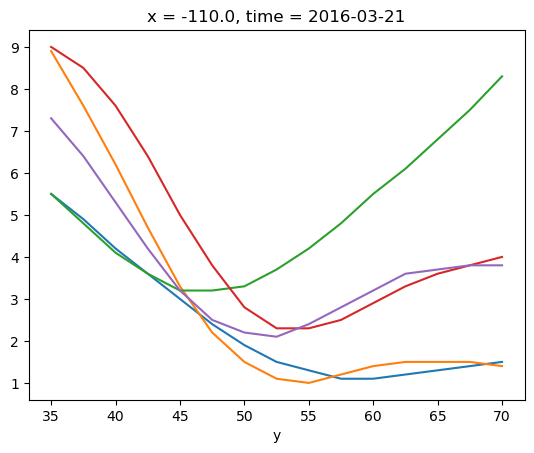

In [135]:
ion_transect.isel(time = 0).plot()
ion_transect.isel(time = 12).plot()
ion_transect.isel(time = 240).plot()
ion_transect.isel(time = 40).plot()
ion_transect.isel(time = 80).plot()

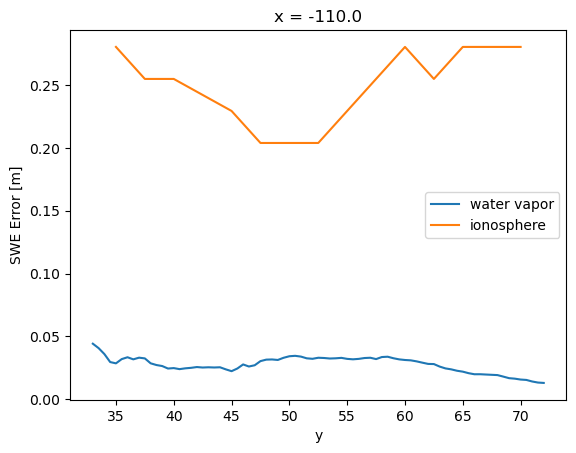

In [136]:
swe_from_phase(precipitable_water(np.abs(pw_transect - pw_transect.shift(time=12)).median('time')/1000)).plot(label = 'water vapor')
swe_from_phase(ionospheric_advance(1e16*np.abs(ion_transect - ion_transect.shift(time=12)).median('time'))).plot(label = 'ionosphere')
plt.ylabel('SWE Error [m]')
plt.legend()